# Preamble

Source: https://gist.github.com/waleedkadous/d06097768abbea54d59e5d3ed4f045f3
text loading modified according to https://python.langchain.com/en/latest/use_cases/question_answering.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma

In [2]:
import langchain
print(langchain.__version__)

0.0.149


# Load document(s)

In [3]:
loader = TextLoader('docs/state_of_the_union.txt', encoding='utf8')

In [4]:
loaded_text = loader.load()

In [5]:
type(loaded_text), len(loaded_text), type(loaded_text[0])

(list, 1, langchain.schema.Document)

## Look at a single document in LangChain format

In [6]:
text = loaded_text[0]
type(text)

langchain.schema.Document

In [7]:
text.metadata, text.dict().keys(), type(text.page_content)

({'source': 'docs/state_of_the_union.txt'},
 dict_keys(['page_content', 'metadata']),
 str)

In [8]:
text.page_content[:100]

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and th'

# Chunk text

We use RecursiveCharacterTextSplitter. It goes over the text and split into chunks according to a certain list of characters: `["\n\n", "\n", " ", ""]`
You define a `chunk_size` which is the maximum size allowed for a chunk. Then that class will split the text trying the list of characters until all chunks fall below that threshold.
I'm not sure what the chunk overlap does as I haven't seen any overlap in the chunks so far


Ref: https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html

https://github.com/hwchase17/langchain/blob/master/langchain/text_splitter.py#L268

In [9]:
RecursiveCharacterTextSplitter?

Init signature:
RecursiveCharacterTextSplitter(
    separators: 'Optional[List[str]]' = None,
    **kwargs: 'Any',
)
Docstring:     
Implementation of splitting text that looks at characters.

Recursively tries to split by different characters to find one
that works.
Init docstring: Create a new TextSplitter.
File:           /usr/local/lib/python3.11/site-packages/langchain/text_splitter.py
Type:           ABCMeta
Subclasses:     MarkdownTextSplitter, LatexTextSplitter, PythonCodeTextSplitter

In [10]:
# The default chunk_overlap is set to 200. Using this increases the smallest 
# chunk length from ~50 to ~100. 
# I'm not 100% clear on what chunk_overlap does but it is used 
# in the _merge_splits method that combines smaller pieces
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    #separators = [" "],
    #chunk_overlap  = 20,
    length_function = len,
)

In [11]:
text_splitter.__dict__

{'_chunk_size': 300,
 '_chunk_overlap': 200,
 '_length_function': <function len(obj, /)>,
 '_separators': ['\n\n', '\n', ' ', '']}

In [12]:
chunks = text_splitter.create_documents([text.page_content])
type(chunks), len(chunks)

(list, 260)

In [13]:
chunks[0]

Document(page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again.', metadata={})

In [14]:
chunk_of_text = text_splitter.split_text(text.page_content)
type(chunk_of_text), len(chunk_of_text)

(list, 260)

In [15]:
chunk_of_text[0]

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again.'

In [16]:
len(text.page_content), len(text.page_content)//(300-40)

(38539, 148)

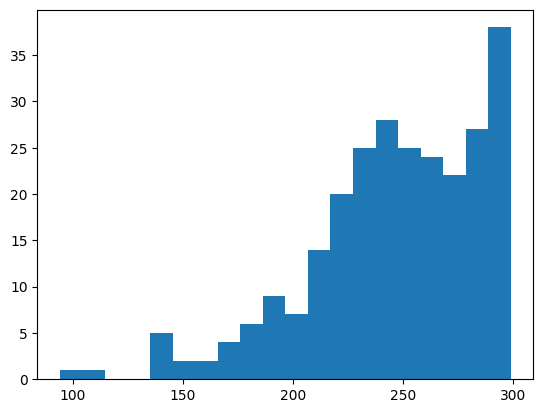

In [17]:
# histogram of the chunk lenghts
len_chunks = np.array([len(chunk) for chunk in chunk_of_text])
plt.hist(len_chunks, bins=20);

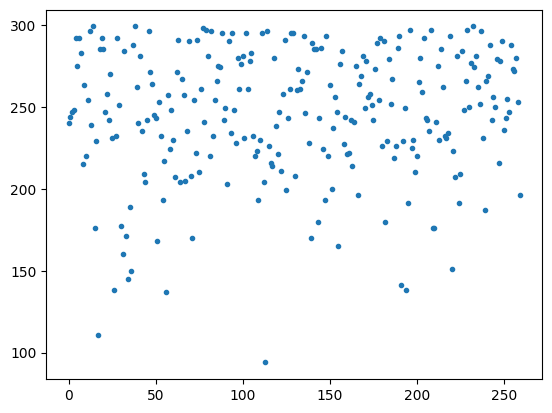

In [18]:
plt.plot(len_chunks, '.')

In [19]:
idx_min_len_chunk = np.argmin(len_chunks)
print(f"idx={idx_min_len_chunk}, len={len(chunk_of_text[idx_min_len_chunk])}")

idx=113, len=94


In [20]:
np.min(len_chunks)

94

In [21]:
for idx in range(idx_min_len_chunk-2, idx_min_len_chunk+2):
    chunk = chunk_of_text[idx]
    print(f"\nChunk #{idx} has length {len(chunk)}")
    print(chunk)


Chunk #111 has length 295
For Joshua, and for the 200,000 other young people with Type 1 diabetes, let’s cap the cost of insulin at $35 a month so everyone can afford it.  

Drug companies will still do very well. And while we’re at it let Medicare negotiate lower prices for prescription drugs, like the VA already does.

Chunk #112 has length 204
Look, the American Rescue Plan is helping millions of families on Affordable Care Act plans save $2,400 a year on their health care premiums. Let’s close the coverage gap and make those savings permanent.

Chunk #113 has length 94
Second – cut energy costs for families an average of $500 a year by combatting climate change.

Chunk #114 has length 296
Let’s provide investments and tax credits to weatherize your homes and businesses to be energy efficient and you get a tax credit; double America’s clean energy production in solar, wind, and so much more;  lower the price of electric vehicles, saving you another $80 a month because you’ll never


In [22]:
text.page_content[-300:]

' stronger today than we were a year ago. \n\nAnd we will be stronger a year from now than we are today. \n\nNow is our moment to meet and overcome the challenges of our time. \n\nAnd we will, as one people. \n\nOne America. \n\nThe United States of America. \n\nMay God bless you all. May God protect our troops.'

# Index the document

In [23]:
embedding_model = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

In [24]:
db = FAISS.from_documents(chunks, embedding_model)

In [31]:
len(db.index_to_docstore_id), len(chunks)

(260, 260)

In [49]:
retriever = db.as_retriever()

In [50]:
retriever.__dict__

{'vectorstore': <langchain.vectorstores.faiss.FAISS at 0x7f4424eb5050>,
 'search_type': 'similarity',
 'search_kwargs': {}}

In [45]:
query = "What did the president say about Ketanji Brown Jackson?"
output = retriever.get_relevant_documents(query)
type(output), len(output)

(list, 4)

In [56]:
for oo in output:
    print("\n")
    print(oo.page_content)



And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.


He was born a soldier. Army National Guard. Combat medic in Kosovo and Iraq. 

Stationed near Baghdad, just yards from burn pits the size of football fields. 

Heath’s widow Danielle is here with us tonight. They loved going to Ohio State football games. He loved building Legos with their daughter.


A former top litigator in private practice. A former federal public defender. And from a family of public school educators and police officers. A consensus builder. Since she’s been nominated, she’s received a broad range of support—from the Fraternal Order of Police to former judges appointed by


public school educators and police officers. A consensus builder. Since she’s been nominated, she’s received a broad range of support—from the Fraternal Order of Police to former judges appointed by Dem

In [69]:
db.similarity_search_with_score(query, k=3)

[(Document(page_content='And I did that 4 days ago, when I nominated Circuit Court of Appeals Judge Ketanji Brown Jackson. One of our nation’s top legal minds, who will continue Justice Breyer’s legacy of excellence.', metadata={}),
  1.0226996),
 (Document(page_content='He was born a soldier. Army National Guard. Combat medic in Kosovo and Iraq. \n\nStationed near Baghdad, just yards from burn pits the size of football fields. \n\nHeath’s widow Danielle is here with us tonight. They loved going to Ohio State football games. He loved building Legos with their daughter.', metadata={}),
  1.2257392),
 (Document(page_content='A former top litigator in private practice. A former federal public defender. And from a family of public school educators and police officers. A consensus builder. Since she’s been nominated, she’s received a broad range of support—from the Fraternal Order of Police to former judges appointed by', metadata={}),
  1.2598848)]

In [61]:
db.index.search?

Signature: db.index.search(x, k, *, params=None, D=None, I=None)
Docstring:
Find the k nearest neighbors of the set of vectors x in the index.

Parameters
----------
x : array_like
    Query vectors, shape (n, d) where d is appropriate for the index.
    `dtype` must be float32.
k : int
    Number of nearest neighbors.
params : SearchParameters
    Search parameters of the current search (overrides the class-level params)
D : array_like, optional
    Distance array to store the result.
I : array_like, optional
    Labels array to store the results.

Returns
-------
D : array_like
    Distances of the nearest neighbors, shape (n, k). When not enough results are found
    the label is set to +Inf or -Inf.
I : array_like
    Labels of the nearest neighbors, shape (n, k).
    When not enough results are found, the label is set to -1
File:      /usr/local/lib/python3.11/site-packages/faiss/class_wrappers.py
Type:      method